In [25]:
#!/usr/bin/env python3 3.7.4 project3 env
# -*- coding: utf-8 -*-
"""
Runs initial training of network model.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from pathlib import Path
from dataset import create_data_velocity_centeroutreach, \
                    create_data_velocity_random, \
                        perturb
from modeldef import RNN,test
import os
import socket
import pandas as pd


In [40]:
directory = Path.cwd() / 'results'
name = 'test'
# name = 'train'
savname = directory / name
params = np.load(savname / 'params.npy',allow_pickle=True).item()
protocol = params['model']['protocol']
for phase in range(len(protocol)):
    training_trials = protocol[phase][2]
    print(training_trials)

loss_list = []

1
1
1
0
0


In [41]:
df = pd.DataFrame(params)
df

,model,data,directory,name,p1
n,400,NaN,/home/jawad/feulner_code_explained/results,test,NaN
tau,0.05,NaN,/home/jawad/feulner_code_explained/results,test,NaN
nonlin,relu,NaN,/home/jawad/feulner_code_explained/results,test,NaN
grec,0.0,NaN,/home/jawad/feulner_code_explained/results,test,NaN
fb_initial,1.0,NaN,/home/jawad/feulner_code_explained/results,test,NaN
fb_sparsity,1.0,NaN,/home/jawad/feulner_code_explained/results,test,NaN
fb_type,poserrorfb,NaN,/home/jawad/feulner_code_explained/results,test,NaN
rec_sparsity,1.0,NaN,/home/jawad/feulner_code_explained/results,test,NaN
in_initial,1.0,NaN,/home/jawad/feulner_code_explained/results,test,NaN
input_dim,3,7,/home/jawad/feulner_code_explained/results,test,NaN


Loading parameters from /home/jawad/feulner_code_explained/results/train/params.npy
RANDOM REACH DATASET CONSTRUCTED!
CENTER OUT REACH DATASET CONSTRUCTED!

####### PHASE 0 ####### ['random', 0, 100]
['random', 0, 100] Epoch=0 | Loss=16.5053 | In=0.0010 | Rec=0.0115 | Out=0.0008 | OutB=0.0000 | Fb=0.0116 | FbB=0.0084 | Act=0.0053
['random', 0, 100] Epoch=10 | Loss=1.2414 | In=0.0010 | Rec=0.0117 | Out=0.0009 | OutB=0.0000 | Fb=0.0116 | FbB=0.0084 | Act=0.0360
['random', 0, 100] Epoch=20 | Loss=1.7390 | In=0.0011 | Rec=0.0118 | Out=0.0009 | OutB=0.0000 | Fb=0.0116 | FbB=0.0084 | Act=0.0305
['random', 0, 100] Epoch=30 | Loss=1.0737 | In=0.0011 | Rec=0.0119 | Out=0.0010 | OutB=0.0000 | Fb=0.0116 | FbB=0.0083 | Act=0.0174
['random', 0, 100] Epoch=40 | Loss=1.0587 | In=0.0012 | Rec=0.0120 | Out=0.0010 | OutB=0.0000 | Fb=0.0116 | FbB=0.0083 | Act=0.0055
['random', 0, 100] Epoch=50 | Loss=1.0464 | In=0.0012 | Rec=0.0120 | Out=0.0010 | OutB=0.0000 | Fb=0.0116 | FbB=0.0083 | Act=0.0083
['random

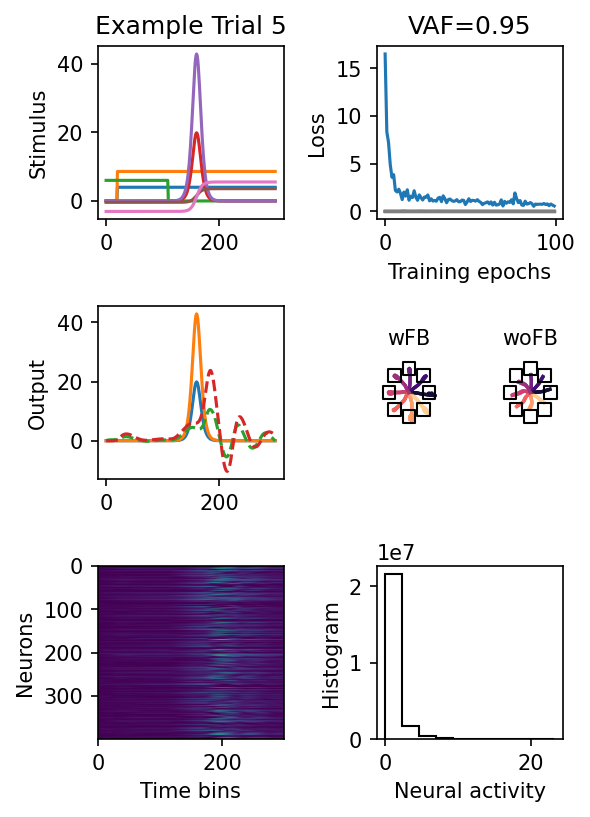

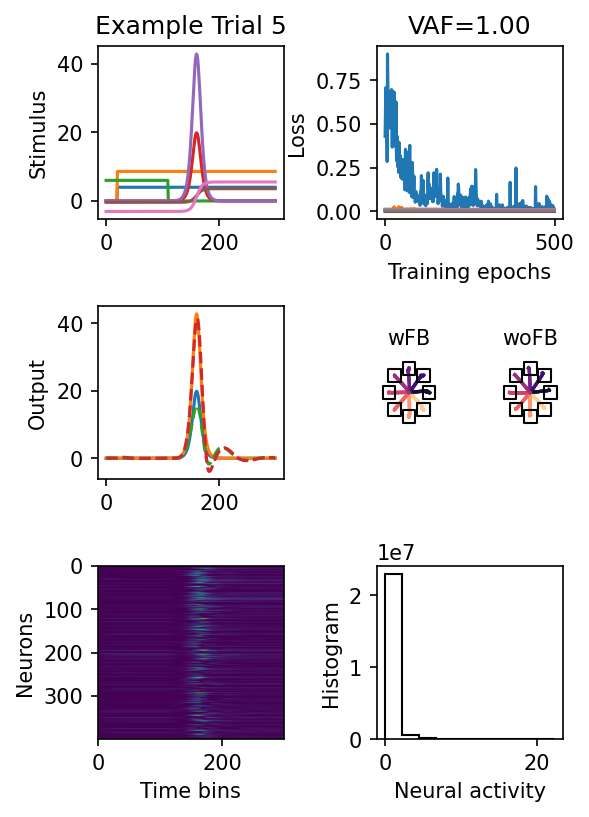

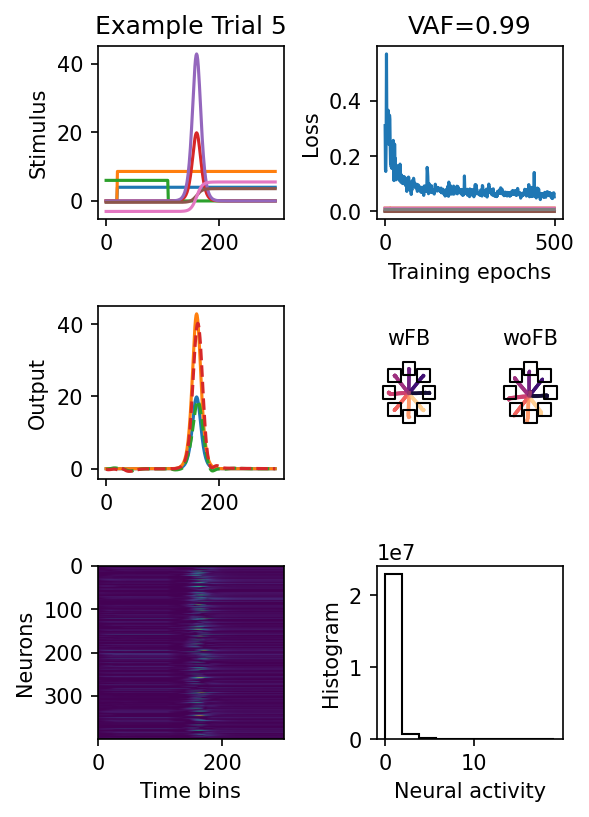

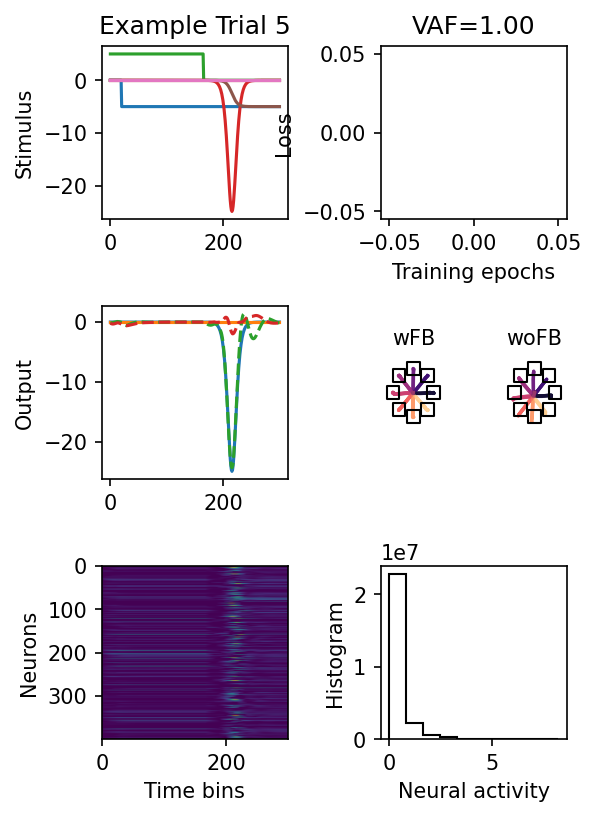

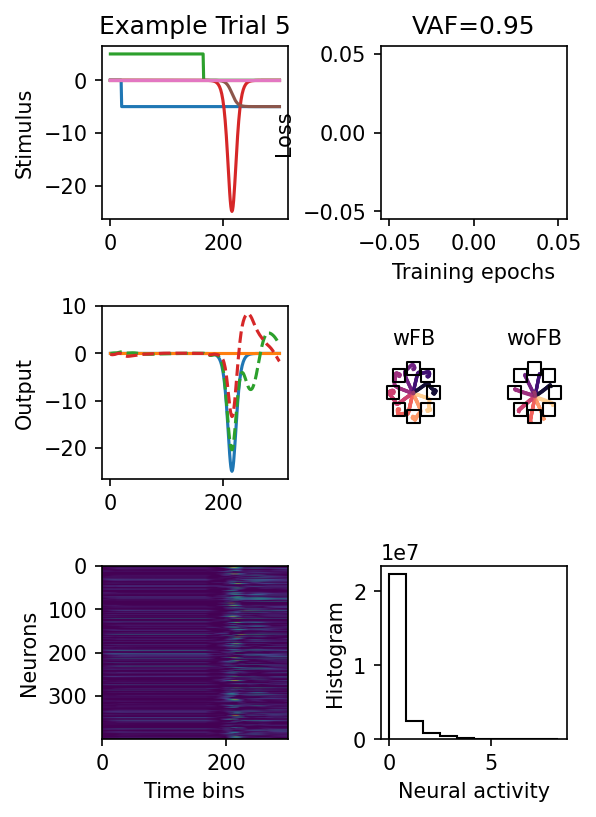

In [45]:
def main(name='train'):
    
    # LOAD PARAMETERS ###################
    directory = Path.cwd() / 'results'
    name = name
    savname = directory / name
        
    fnf_params = savname / 'params.npy'
    print('Loading parameters from %s'%fnf_params)
    params = np.load(fnf_params,allow_pickle=True).item()

    # params = np.load(savname/'params.npy',allow_pickle=True).item()
    protocol = params['model']['protocol']
    
    if directory!=params['directory'] or name!=params['name']:
        print('Naming is inconsistent!')
        return 0 
    
    # SETUP SIMULATION #################
    rand_seed = params['model']['rand_seed']
    np.random.seed(rand_seed)
    torch.manual_seed(rand_seed)
    
    # GPU usage 
    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        torch.set_default_device('cuda')
    else:
        dtype = torch.FloatTensor
        torch.set_default_device('cpu')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    params['model'].update({'dtype':dtype,'device':device})
    
    # CREATE DATA ###################
    dataA = create_data_velocity_random(params['data'])
    dataB = create_data_velocity_centeroutreach(params['data'])
    data0 = {'random':dataA,'center-out-reach':dataB}
        
    # SETUP MODEL #################
    model = RNN(params['model']['input_dim'],
                params['model']['output_dim'],
                params['model']['n'],
                params['model']['dt']/params['model']['tau'],
                dtype,
                params['model']['dt'],
                params['model']['fwd_delay'],
                params['model']['fb_delay'],
                fb_sparsity=params['model']['fb_sparsity'],
                nonlin=params['model']['nonlin'],
                noiseout=params['model']['noise_amp'],
                noise_kernel_size=params['model']['noise_kernel_size'],
                noisein=params['model']['noise_stim_amp'],
                rec_sparsity=params['model']['rec_sparsity'])
       
    # recurrent initialization
    if params['model']['grec']!=0:
        tmp = model.state_dict()
        tmp['rnn.weight_hh_l0'] = torch.FloatTensor(
            params['model']['grec']/np.sqrt(params['model']['n']) \
            * np.random.randn(params['model']['n'],params['model']['n'])).type(dtype)
        model.load_state_dict(tmp,strict=True)
    
    # input initialization
    tmp = model.state_dict()
    tmp['rnn.weight_ih_l0'] = params['model']['in_initial']*tmp['rnn.weight_ih_l0']
    model.load_state_dict(tmp,strict=True)
    
    # SETUP OPTIMIZER #################
    criterion = nn.MSELoss(reduction='none') 
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=params['model']['lr']) 
    
    # START INITIAL TRAINING #################
    # usually first there are several random phases and then two cetner-out-reach phases
    # first random phase with static fb weights, then with changing fb weights, 
    # then with random pertbation on
    # then center-out-reach without perturbation, then with VMR perturbation 
    for phase in range(len(protocol)):
        print('\n####### PHASE %d #######'%phase, protocol[phase])
        if phase==0: # fix fb weights in first training phase
            tmp = model.state_dict()
            tmp['feedback.weight'] *= params['model']['fb_initial']
            model.load_state_dict(tmp,strict=True)
            model.feedback.weight.requires_grad = False
            np.save(savname / 'data',data0)
        else:
            model.feedback.weight.requires_grad = True

        data_cur_phase = data0[protocol[phase][0]] # data0 is a dict with two keys: random and center-out-reach
        #data_cur_phase is a dict with keys ['params', 'target', 'peak_speed', 'stimulus', 'test_set']
        perturbation_type = protocol[phase][1]
        n_training_trials = protocol[phase][2]
        tout  = data_cur_phase['target'][:,:,2:] # target behavior, here we take only postiion info
        tstim = data_cur_phase['stimulus']
        #tout.shape (1802, 300, 2)
        #tstim.shape (1802, 300, 7)
        # rotate output matrix if perturbation type is VR (2)
        if perturbation_type == 2:
            rot_phi = params['model']['rot_phi']
            rotmat = np.array([[np.cos(rot_phi),-np.sin(rot_phi)],
                                [np.sin(rot_phi),np.cos(rot_phi)]])
            state_dict = model.state_dict()
            state_dict['output.weight'] = dtype(rotmat) @ \
                                            state_dict['output.weight']
            model.load_state_dict(state_dict, strict=True)
        # convert to pytorch form
        tpl = n_training_trials, params['model']['tsteps'], params['model']['batch_size']
        stimulus = torch.zeros(*tpl, tstim.shape[-1]).type(dtype)
        pert     = torch.zeros(*tpl, params['model']['output_dim']).type(dtype)
        # target is not used later (it is in fact contained in stimulus)
        #target   = torch.zeros(*tpl, params['model']['output_dim']).type(dtype)

        # population target and stimiulus with data and  
        # prepare random velocity pert if necessary
        for j in range(n_training_trials):
            idx = np.random.choice(range(tout.shape[0]),params['model']['batch_size'],
                                   replace=False)
            #target[j]   = torch.Tensor( tout[idx].transpose(1,0,2)).type(dtype)
            stimulus[j] = torch.Tensor(tstim[idx].transpose(1,0,2)).type(dtype)
            # insert perturbation if perturbation type is random push (1)
            if perturbation_type == 1:
                pert[j] = perturb(pert[j],params['model']['batch_size'],params['p1'])
        # ACTUAL TRAINING STARTS
        lc = []
        model.train()
        for epoch in range(n_training_trials): 
            toprint = OrderedDict()
            optimizer.zero_grad()
            output,hidden   = model(stimulus[epoch],pert[epoch]) # runs forward
            loss_train      = criterion(output, output*0).mean() # we compare output (errors per trial) with 0
            toprint['Loss'] = loss_train
            
            # add regularization
            # term 1: parameters
            regin   = params['model']['alpha1']*model.rnn.weight_ih_l0.norm(2)
            regout  = params['model']['alpha1']*model.output.weight.norm(2)
            regoutb = params['model']['alpha1']*model.output.bias.norm(2)
            regfb   = params['model']['alpha1']*model.feedback.weight.norm(2)
            regfbb  = params['model']['alpha1']*model.feedback.bias.norm(2)
            regrec  = params['model']['gamma1']*model.rnn.weight_hh_l0.norm(2)

            toprint['In']   = regin
            toprint['Rec']  = regrec
            toprint['Out']  = regout
            toprint['OutB'] = regoutb
            toprint['Fb']   = regfb
            toprint['FbB']  = regfbb

            # term 2: rates
            regact = params['model']['beta1']*hidden.pow(2).mean() 
            toprint['Act'] = regact
         
            loss = loss_train+regin+regrec+regout+regoutb+regact+regfbb+regfb
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                           params['model']['clipgrad'])
            optimizer.step()
                
            train_running_loss = [loss_train.detach().item(),regact.detach().item(),
                                  regin.detach().item(), regrec.detach().item(),
                                  regout.detach().item(), regoutb.detach().item(),
                                  regfb.detach().item(), regfbb.detach().item()]

            if epoch % 10 == 0:
                print(protocol[phase],('Epoch=%d | '%(epoch)) +" | ".join("%s=%.4f"%(k, v) for \
                                                      k, v in toprint.items()))
            lc.append(train_running_loss)       
            # end of cycle over training epochs

        # save this phase
        torch.save({'epoch': n_training_trials,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lc':np.array(lc),
                    'params':params
                    }, savname / ('phase'+str(phase)+'_training'))
        print('MODEL TRAINED!')

        # test model
        model.eval()
        test(model,data_cur_phase,params,str(savname / ('phase'+str(phase)+'_')),lc,
                      dopert=0 if perturbation_type==2 else perturbation_type,
                      dataC=dataB)
        print('MODEL TESTED!')
        # end of cycle over phases

if __name__ == "__main__":
    main()
     

In [ ]:
# SETUP SIMULATION #################
rand_seed = params['model']['rand_seed']
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

# GPU usage 
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    torch.set_default_device('cuda')
else:
    dtype = torch.FloatTensor
    torch.set_default_device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params['model'].update({'dtype':dtype,'device':device})

# CREATE DATA ###################
dataA = create_data_velocity_random(params['data'])
dataB = create_data_velocity_centeroutreach(params['data'])
data0 = {'random':dataA,'center-out-reach':dataB}
    
# SETUP MODEL #################
model = RNN(params['model']['input_dim'],
            params['model']['output_dim'],
            params['model']['n'],
            params['model']['dt']/params['model']['tau'],
            dtype,
            params['model']['dt'],
            params['model']['fwd_delay'],
            params['model']['fb_delay'],
            fb_sparsity=params['model']['fb_sparsity'],
            nonlin=params['model']['nonlin'],
            noiseout=params['model']['noise_amp'],
            noise_kernel_size=params['model']['noise_kernel_size'],
            noisein=params['model']['noise_stim_amp'],
            rec_sparsity=params['model']['rec_sparsity'])
    
# recurrent initialization
if params['model']['grec']!=0:
    tmp = model.state_dict()
    tmp['rnn.weight_hh_l0'] = torch.FloatTensor(
        params['model']['grec']/np.sqrt(params['model']['n']) \
        * np.random.randn(params['model']['n'],params['model']['n'])).type(dtype)
    model.load_state_dict(tmp,strict=True)

# input initialization
tmp = model.state_dict()
tmp['rnn.weight_ih_l0'] = params['model']['in_initial']*tmp['rnn.weight_ih_l0']
model.load_state_dict(tmp,strict=True)

# SETUP OPTIMIZER #################
criterion = nn.MSELoss(reduction='none') 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=params['model']['lr']) 

# START INITIAL TRAINING #################
# usually first there are several random phases and then two cetner-out-reach phases
# first random phase with static fb weights, then with changing fb weights, 
# then with random pertbation on
# then center-out-reach without perturbation, then with VMR perturbation 
for phase in range(len(protocol)):
    print('\n####### PHASE %d #######'%phase, protocol[phase])
    if phase==0: # fix fb weights in first training phase
        tmp = model.state_dict()
        tmp['feedback.weight'] *= params['model']['fb_initial']
        model.load_state_dict(tmp,strict=True)
        model.feedback.weight.requires_grad = False
        np.save(savname / 'data',data0)
    else:
        model.feedback.weight.requires_grad = True

    data_cur_phase = data0[protocol[phase][0]] # data0 is a dict with two keys: random and center-out-reach
    #data_cur_phase is a dict with keys ['params', 'target', 'peak_speed', 'stimulus', 'test_set']
    perturbation_type = protocol[phase][1]
    n_training_trials = protocol[phase][2]
    tout  = data_cur_phase['target'][:,:,2:] # target behavior, here we take only postiion info
    tstim = data_cur_phase['stimulus']
    #tout.shape (1802, 300, 2)
    #tstim.shape (1802, 300, 7)
    # rotate output matrix if perturbation type is VR (2)
    if perturbation_type == 2:
        rot_phi = params['model']['rot_phi']
        rotmat = np.array([[np.cos(rot_phi),-np.sin(rot_phi)],
                            [np.sin(rot_phi),np.cos(rot_phi)]])
        state_dict = model.state_dict()
        state_dict['output.weight'] = dtype(rotmat) @ \
                                        state_dict['output.weight']
        model.load_state_dict(state_dict, strict=True)
    # convert to pytorch form
    tpl = n_training_trials, params['model']['tsteps'], params['model']['batch_size']
    stimulus = torch.zeros(*tpl, tstim.shape[-1]).type(dtype)
    pert     = torch.zeros(*tpl, params['model']['output_dim']).type(dtype)
    # target is not used later (it is in fact contained in stimulus)
    #target   = torch.zeros(*tpl, params['model']['output_dim']).type(dtype)

    # population target and stimiulus with data and  
    # prepare random velocity pert if necessary
    for j in range(n_training_trials):
        idx = np.random.choice(range(tout.shape[0]),params['model']['batch_size'],
                                replace=False)
        #target[j]   = torch.Tensor( tout[idx].transpose(1,0,2)).type(dtype)
        stimulus[j] = torch.Tensor(tstim[idx].transpose(1,0,2)).type(dtype)
        # insert perturbation if perturbation type is random push (1)
        if perturbation_type == 1:
            pert[j] = perturb(pert[j],params['model']['batch_size'],params['p1'])
    # ACTUAL TRAINING STARTS
    lc = []
    model.train()
    for epoch in range(n_training_trials): 
        toprint = OrderedDict()
        optimizer.zero_grad()
        output,hidden   = model(stimulus[epoch],pert[epoch]) # runs forward
        loss_train      = criterion(output, output*0).mean() # we compare output (errors per trial) with 0
        toprint['Loss'] = loss_train
        
        # add regularization
        # term 1: parameters
        regin   = params['model']['alpha1']*model.rnn.weight_ih_l0.norm(2)
        regout  = params['model']['alpha1']*model.output.weight.norm(2)
        regoutb = params['model']['alpha1']*model.output.bias.norm(2)
        regfb   = params['model']['alpha1']*model.feedback.weight.norm(2)
        regfbb  = params['model']['alpha1']*model.feedback.bias.norm(2)
        regrec  = params['model']['gamma1']*model.rnn.weight_hh_l0.norm(2)

        toprint['In']   = regin
        toprint['Rec']  = regrec
        toprint['Out']  = regout
        toprint['OutB'] = regoutb
        toprint['Fb']   = regfb
        toprint['FbB']  = regfbb

        # term 2: rates
        regact = params['model']['beta1']*hidden.pow(2).mean() 
        toprint['Act'] = regact
        
        loss = loss_train+regin+regrec+regout+regoutb+regact+regfbb+regfb
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                        params['model']['clipgrad'])
        optimizer.step()
            
        train_running_loss = [loss_train.detach().item(),regact.detach().item(),
                                regin.detach().item(), regrec.detach().item(),
                                regout.detach().item(), regoutb.detach().item(),
                                regfb.detach().item(), regfbb.detach().item()]

        if epoch % 10 == 0:
            print(protocol[phase],('Epoch=%d | '%(epoch)) +" | ".join("%s=%.4f"%(k, v) for \
                                                    k, v in toprint.items()))
        lc.append(train_running_loss)       
        # end of cycle over training epochs

    # save this phase
    torch.save({'epoch': n_training_trials,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lc':np.array(lc),
                'params':params
                }, savname / ('phase'+str(phase)+'_training'))
    print('MODEL TRAINED!')

    # test model
    model.eval()
    test(model,data_cur_phase,params,str(savname / ('phase'+str(phase)+'_')),lc,
                    dopert=0 if perturbation_type==2 else perturbation_type,
                    dataC=dataB)
    print('MODEL TESTED!')
    # end of cycle over phases

